# ANÁLISIS DESCRIPTIVO

A continuación se presenta una descripción y visualización de los datos

In [1]:
# IMPORTS
import sys
import json
from pathlib import Path
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import matplotlib.ticker as ticker

# SET PROJECT FOLDER
project_folder = Path.cwd().parent.parent

# LOAD LOCAL_SETUP_CONFIG FILE
config_path = project_folder / "local_setup_config.json"
if config_path.exists():
    with open(config_path, "r", encoding="utf-8") as file:
        local_config  = json.load(file)
    print('Local configuration file loaded succesfully')
else:
    raise FileNotFoundError(f"Error: {config_path} not found")

# set run_local
run_local = local_config["run_local"]

# MODULE PATHS
scripts_folder = project_folder / "Scripts"
sys.path.append(str(scripts_folder))

# MODULE IMPORTS
import test_script
import load_database

# LOAD DATABASE
load_database.load_db(project_folder)

# DATABASE CONNECTION
if run_local:
    linkedindatabase_path = project_folder / "database" / "linkedindatabase.db"
else:
    linkedindatabase_path = project_folder / "database" / "linkedindatabase.db"

if linkedindatabase_path.exists():
    conn = sqlite3.connect(linkedindatabase_path)
    print("Opened database successfully")
else:
    raise FileNotFoundError(f"Error: {linkedindatabase_path} not found")

Local configuration file loaded succesfully
Project folder set to c:\Users\Sarah\Code\ProyectoABD for load_database.py
You're running on local
Database already loaded!
Opened database successfully


In [2]:
#DATAFRAMES CREATION

#numerical data
df_num = pd.read_sql('SELECT * FROM clean_numerical_postings', conn)

df_num = df_num[df_num['max_salary'] <= 10000000]
df_num = df_num[df_num['min_salary'] <= 10000000]
df_num = df_num[df_num['normalized_salary'] <= 10000000]

df_num = df_num[df_num['max_salary'] > 100]
df_num = df_num[df_num['min_salary'] > 100]
df_num = df_num[df_num['normalized_salary'] > 100]

#postings
df_postings = pd.read_sql('SELECT * FROM postings', conn)

#companies
df_companies = pd.read_sql('SELECT * FROM companies', conn)

#industries
df_industries = pd.read_sql('SELECT * FROM industries', conn)

#job industries
df_job_industries = pd.read_sql('SELECT * FROM job_industries', conn)

#skills
df_skills = pd.read_sql('SELECT * FROM skills', conn)

#job skills
df_job_skills = pd.read_sql('SELECT * FROM job_skills', conn)



In [22]:
#FUNCTIONS

#Convert dict to Markdown table
def dict_to_markdown(data):
    headers= "| " + " | ".join(data.keys()) + " |"
    separator = "| " + " | ".join(["---"]*len(data)) + " |"
    rows = []
    for i in range(len(next(iter(data.values())))):
        row = "| " + " | ".join(f"{data[key][i]:,}" if isinstance(data[key][i], float) else str(data[key][i])for key in data) + " |"
        rows.append(row)
    return "\n".join([headers, separator] + rows)

#Convert dict to Dataframe table
def dict_to_dataframe_table(data:dict,cols_key:str):
    data_keys = [*data]
    data_keys.remove(cols_key)
    subset_data = {k: data[k] for k in data_keys}
    return pd.DataFrame.from_dict(subset_data, orient='index', columns=data[cols_key])

# Calcular coef. de asimetría de cada columna
def asim(col):
    # Calculamos la media de la columna
    media = col.mean()

    # Calculamos la desviacion estandar
    std = col.std()

    # Calculamos el 3er momento alrededor del centro
    momento_3 = ((col - media) ** 3).mean()

    asim = momento_3*(1/(std**3))
    return asim

#convert unix time to days, hours, minutes
def convert_time(duration):
    days = int(duration//86400)
    hours = int((duration%86400)//3600)
    minutes = round((duration%3600)/60,1)
    return f"{days}d{hours}h{minutes}m"

## Análisis Estadístico Básico

se realiza un análisis estadístico básico para los siguientes atributos de cada publicación de trabajo:

* Rango Salarial ofrecido para el puesto
* Número de vistas
* Número de aplicaciones recibidas
* Duración de la publicación

se visualizan algunas medidas de centralización y de dispersión

### Rango salarial

In [139]:
nor_salary_insights = df_num[df_num['normalized_salary'].notnull()]
nor_salary_insights = nor_salary_insights.sort_values(by='normalized_salary', ascending=False)
nor_salary_insights = nor_salary_insights[nor_salary_insights['normalized_salary'] != 0]
nor_salary_insights.rename(columns={'normalized_salary': 'salary'}, inplace=True)
nor_salary_insights['category'] = 'normalized_salary'

max_salary_insights = df_num[df_num['max_salary'].notnull()]
max_salary_insights = max_salary_insights.sort_values(by='max_salary', ascending=False)
max_salary_insights = max_salary_insights[max_salary_insights['max_salary'] != 0]
max_salary_insights.rename(columns={'max_salary': 'salary'}, inplace=True)
max_salary_insights['category'] = 'max_salary'

min_salary_insights = df_num[df_num['min_salary'].notnull()]
min_salary_insights = min_salary_insights.sort_values(by='min_salary', ascending=False)
min_salary_insights = min_salary_insights[min_salary_insights['min_salary'] != 0]
min_salary_insights.rename(columns={'min_salary': 'salary'}, inplace=True)
min_salary_insights['category'] = 'min_salary'

salary_combined = pd.concat([nor_salary_insights, max_salary_insights, min_salary_insights], ignore_index=True)


#### Medidas de Centralización

In [24]:
#mean salary

mean_salary = nor_salary_insights['salary'].mean()
mean_salary_max = max_salary_insights['salary'].mean()
mean_salary_min = min_salary_insights['salary'].mean()

#median salary

median_salary = nor_salary_insights['salary'].median()
median_salary_max = max_salary_insights['salary'].median()
median_salary_min = min_salary_insights['salary'].median()

#mode salary

mode_salary = nor_salary_insights['salary'].mode()
mode_salary_max = max_salary_insights['salary'].mode()
mode_salary_min = min_salary_insights['salary'].mode()


cent_data = {
    'Medida': ['Promedio', 'Mediana', 'Moda'],
    'Salario medio': [int(mean_salary), median_salary, float(mode_salary[0])],
    'Salario máximo': [int(mean_salary_max), median_salary_max, float(mode_salary_max[0])],
    'Salario mínimo': [int(mean_salary_min), median_salary_min, float(mode_salary_min[0])]
}



# Display Markdown table
#markdown_table = dict_to_markdown(cent_data)
#display(Markdown(markdown_table))

# Display pandas dataframe table
dict_to_dataframe_table(cent_data,'Medida')


,Promedio,Mediana,Moda
Salario medio,103627,90000.0,100000.0
Salario máximo,119840,102880.0,150000.0
Salario mínimo,87412,76500.0,100000.0


#### Medidas de Dispersión

In [25]:
#varianza
var_salary = nor_salary_insights['salary'].var()
var_salary_max = max_salary_insights['salary'].var()
var_salary_min = min_salary_insights['salary'].var()

#desviacion estandar
std_salary = nor_salary_insights['salary'].std()
std_salary_max = max_salary_insights['salary'].std()
std_salary_min = min_salary_insights['salary'].std()

#max
max_salary = nor_salary_insights['salary'].max()
max_salary_max = max_salary_insights['salary'].max()
max_salary_min = min_salary_insights['salary'].max()
#min
min_salary = nor_salary_insights['salary'].min()
min_salary_max = max_salary_insights['salary'].min()
min_salary_min = min_salary_insights['salary'].min()
#rango
range_salary = max_salary - min_salary
range_salary_max = max_salary_max - min_salary_max
range_salary_min = max_salary_min - min_salary_min

#coef asimetria
asim_salary = asim(nor_salary_insights['salary'])
asim_salary_max = asim(max_salary_insights['salary'])
asim_salary_min = asim(min_salary_insights['salary'])

#curtosis
kurt_salary = nor_salary_insights['salary'].kurt()
kurt_salary_max = max_salary_insights['salary'].kurt()
kurt_salary_min = min_salary_insights['salary'].kurt()

disp_data = {
    'Medida': ['Varianza', 'Desviación Estándar', 'Rango', 'Coeficiente de Asimetría', 'Curtosis'],
    'Salario medio': [var_salary, std_salary, (min_salary,max_salary), asim_salary, kurt_salary],
    'Salario máximo': [var_salary_max, std_salary_max, (min_salary_max,max_salary_max), asim_salary_max, kurt_salary_max],
    'Salario mínimo': [var_salary_min, std_salary_min, (min_salary_min,max_salary_min), asim_salary_min, kurt_salary_min]
}


# Display Markdown table
#markdown_table = dict_to_markdown(disp_data)
#display(Markdown(markdown_table))

# Display pandas dataframe table
dict_to_dataframe_table(disp_data,'Medida')

,Varianza,Desviación Estándar,Rango,Coeficiente de Asimetría,Curtosis
Salario medio,4.402867e+09,66354.103394,"(110.0, 2096744.0)",6.070477,119.153350
Salario máximo,6.947264e+09,83350.246632,"(115.0, 2339090.0)",5.878229,92.899850
Salario mínimo,2.960661e+09,54411.957313,"(105.0, 1854398.0)",6.717392,153.637039


#### Análisis Intercuartílico

#### Visualización

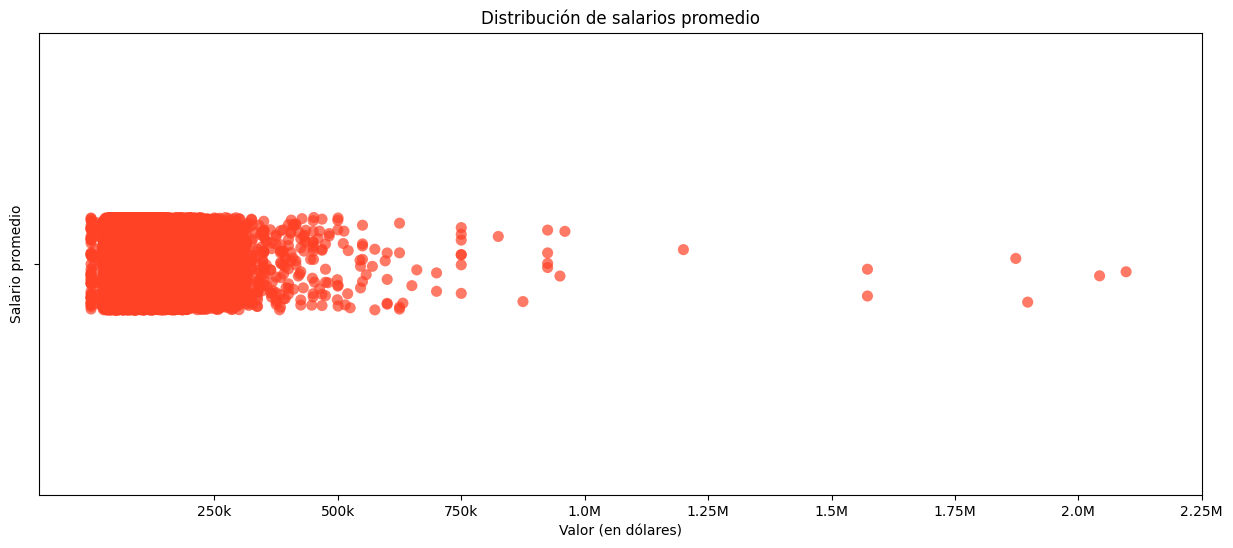

In [148]:
plt.figure(figsize=(15, 6))
sns.stripplot(x='salary', y='category', data=nor_salary_insights, jitter=True, size=8, hue='category',palette='CMRmap', alpha=0.7)
def label(value):
    if value//1000000 > 0:
        label= f'{value/1000000:,}M'
    else:
        label= f'{int(value/1000):,}k'
    return label
plt.xticks(ticks=np.arange(250000, 2500000, 250000), labels=[label(i) for i in np.arange(250000, 2500000, 250000)])
plt.yticks(ticks=[0], labels=[''])
plt.ylabel('Salario promedio')
plt.xlabel('Valor (en dólares)')
plt.title('Distribución de salarios promedio')

plt.show()

Los salarios tienden a concentrarse en valores bajos y medianos, con pocas ofertas de trabajo que superan los 400k dólares.
Hay algunos valores extremos en la parte derecha, lo que indica que existen salarios significativamente más altos, pero en menor cantidad.
La distribución sugiere que el mercado laboral tiene una gran cantidad de ofertas con salarios relativamente bajos, mientras que los salarios más altos son menos frecuentes.

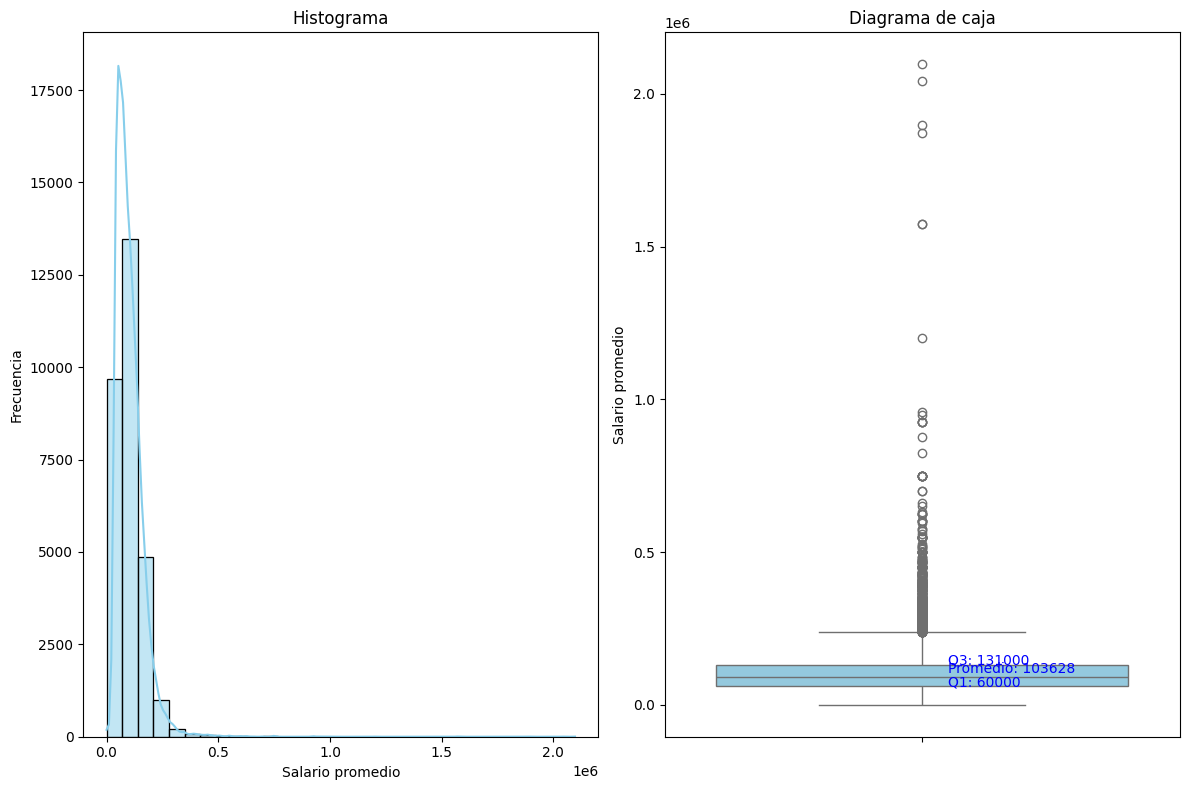

In [149]:
salary = df_num['normalized_salary'].dropna()

colors = sns.color_palette('viridis', 30)
# Plotting the histogram
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)  # (rows, columns, index)
sns.histplot(salary, kde=True, color='skyblue', bins=30)
plt.title('Histograma')
plt.xlabel('Salario promedio')
plt.ylabel('Frecuencia')

# Calculate mean and quartiles
mean_value = np.mean(salary)
q1 = np.percentile(salary, 25)
q3 = np.percentile(salary, 75)

# Plotting the boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=salary, color='skyblue', orient='v')
plt.title('Diagrama de caja')
plt.ylabel('Salario promedio')

# Annotate the mean and quartile values on the boxplot
plt.text(0.05, mean_value, f'Promedio: {mean_value:.0f}', color='blue', fontsize=10)
plt.text(0.05, q1, f'Q1: {q1:.0f}', color='blue', fontsize=10)
plt.text(0.05, q3, f'Q3: {q3:.0f}', color='blue', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()

El histograma sugiere que la mayoría de los salarios se concentran en un rango específico, pero hay presencia de valores extremos.
El diagrama de caja confirma la presencia de valores atípicos y muestra la mediana y los cuartiles.

### Visitas y Aplicaciones

In [127]:
views = df_num['views'].dropna()
apps = df_num['applies'].dropna()

#### Medidas de Centralización

In [128]:
#mean views
mean_views = views.mean()

#median views
median_views = views.median()

#mode views
mode_views = views.mode()


#mean apps
mean_apps = apps.mean()

#median apps
median_apps = apps.median()

#mode apps
mode_apps = apps.mode()

cent_data_views = {
    'Medida': ['Promedio', 'Mediana', 'Moda'],
    'Número de vistas': [mean_views, median_views, mode_views[0]],
}

# Display Markdown table
#markdown_table = dict_to_markdown(cent_data_views)
#display(Markdown(markdown_table))

# Display pandas dataframe table
#dict_to_dataframe_table(cent_data_views,'Medida')

cent_data_apps = {
    'Medida': ['Promedio', 'Mediana', 'Moda'],
    'Número de aplicaciones': [round(mean_apps,3), median_apps, mode_apps[0]],
}

# Display Markdown table
#markdown_table = dict_to_markdown(cent_data_apps)
#display(Markdown(markdown_table))

# Display pandas dataframe table
#dict_to_dataframe_table(cent_data_apps,'Medida')

cent_data_views_apps = {
    'Medida': ['Promedio', 'Mediana', 'Moda'],
    'Número de vistas': [round(mean_views,3), median_views, mode_views[0]],
    'Número de aplicaciones': [round(mean_apps,3), median_apps, mode_apps[0]]
}

# Display Markdown table
#markdown_table = dict_to_markdown(cent_data_apps)
#display(Markdown(markdown_table))

# Display pandas dataframe table
dict_to_dataframe_table(cent_data_views_apps,'Medida')

,Promedio,Mediana,Moda
Número de vistas,21.301,5.0,4.0
Número de aplicaciones,12.036,3.0,1.0


#### Medidas de Dispersión

In [129]:
#varianza
var_views = views.var()

#desviacion estandar
std_views = views.std()

#max
max_views = views.max()

#min
min_views = views.min()

#rango
range_views = max_views - min_views

#coef asimetria
asim_views = asim(views)

#curtosis
kurt_views = views.kurt()

#varianza
var_apps = apps.var()

#desviacion estandar
std_apps = apps.std()

#max
max_apps = apps.max()

#min
min_apps = apps.min()

#rango
range_apps = max_apps - min_apps

#coef asimetria
asim_apps = asim(apps)

#curtosis
kurt_apps = apps.kurt()


disp_data_views = {
    'Medida': ['Varianza', 'Desviación Estándar', 'Rango', 'Coeficiente de Asimetría', 'Curtosis'],
    'Número de vistas': [var_views, std_views, (min_views,max_views), asim_views, kurt_views]
}

# Display Markdown table
#markdown_table = dict_to_markdown(disp_data_views)
#display(Markdown(markdown_table))

# Display pandas dataframe table
#dict_to_dataframe_table(disp_data_views,'Medida')


disp_data_apps = {
    'Medida': ['Varianza', 'Desviación Estándar', 'Rango', 'Coeficiente de Asimetría', 'Curtosis'],
    'Número de aplicaciones': [round(var_apps,3), round(std_apps,3), (int(min_apps),int(max_apps)), round(asim_apps,3), round(kurt_apps,3)]
}



# Display Markdown table
#markdown_table = dict_to_markdown(disp_data)
#display(Markdown(markdown_table))

# Display pandas dataframe table
#dict_to_dataframe_table(disp_data_apps,'Medida')

disp_data_views_apps = {
    'Medida': ['Varianza', 'Desviación Estándar', 'Rango', 'Coeficiente de Asimetría', 'Curtosis'],
    'Número de vistas': [round(var_views,3), round(std_views,3), (int(min_views),int(max_views)), round(asim_views,3), round(kurt_views,3)],
    'Número de aplicaciones': [round(var_apps,3), round(std_apps,3), (int(min_apps),int(max_apps)), round(asim_apps,3), round(kurt_apps,3)],
}



# Display Markdown table
#markdown_table = dict_to_markdown(disp_data)
#display(Markdown(markdown_table))

# Display pandas dataframe table
dict_to_dataframe_table(disp_data_views_apps,'Medida')

,Varianza,Desviación Estándar,Rango,Coeficiente de Asimetría,Curtosis
Número de vistas,17895.015,133.772,"(1, 9975)",41.728,2524.889
Número de aplicaciones,1128.246,33.589,"(1, 967)",9.604,157.131


#### Análisis Intercuartílico

#### Visualización

In [130]:
view_counts = views.value_counts()
df_views = pd.DataFrame(view_counts)
df_views = df_views.reset_index().rename(columns={'views':'valores','count': 'count'})


app_counts = apps.value_counts()
df_apps = pd.DataFrame(app_counts)
df_apps = df_apps.reset_index().rename(columns={'applies':'valores','count': 'count'})

#culumn to differentiate datasets
df_views['Tipo']= 'Vistas'
df_apps['Tipo']= 'Aplicaciones'

#combine datasets
df_views_apps = pd.concat([df_views,df_apps])

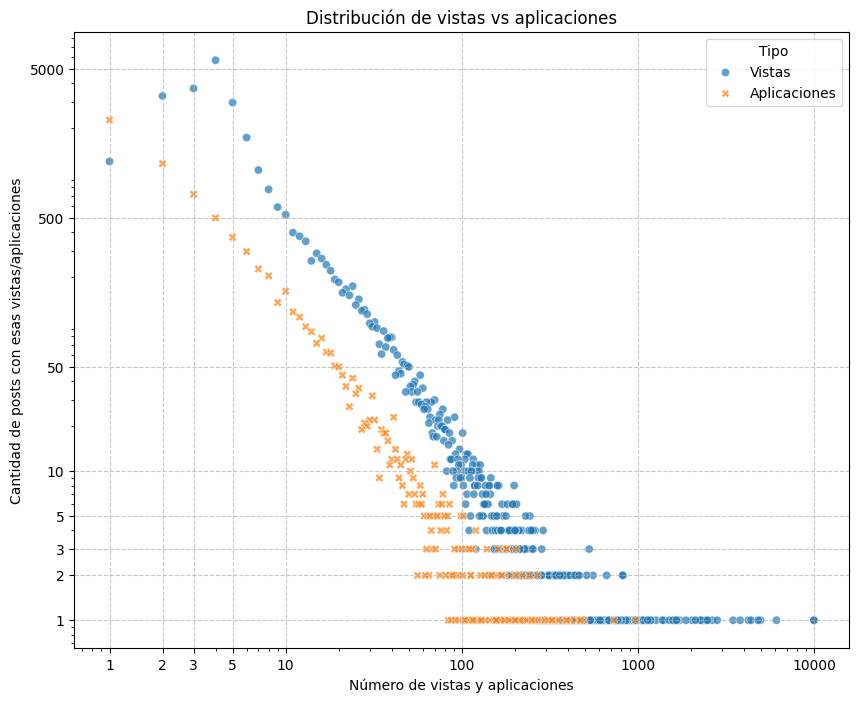

In [131]:
import matplotlib.ticker as ticker

palette = {'Vistas': 'blue', 'Aplicaciones': 'red'}
plt.figure(figsize=(10, 8))
sns.scatterplot(x='valores', y='count',data=df_views_apps, hue='Tipo',style='Tipo', alpha=0.7)

#plt.xticks(ticks=np.arange(0, 10000, 500), labels=[f'{int(i/1):,}' for i in np.arange(0, 10000, 500)])
#plt.yticks(ticks=np.arange(0, 6000, 500), labels=[f'{int(i/1):,}' for i in np.arange(0, 6000, 500)])
#plt.yticks(ticks=[0], labels=[''])
plt.ylabel('Cantidad de posts con esas vistas/aplicaciones')
plt.xlabel('Número de vistas y aplicaciones')
plt.title('Distribución de vistas vs aplicaciones')

# Set the x and y axes to a logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Custom tick values for x and y axes
x_ticks = [1, 2, 3, 5, 10, 100, 1000, 10000]  # Example tick values for the x-axis
y_ticks = [1, 2, 3, 5, 10, 50, 500, 5000]  # Example tick values for the y-axis

# Apply custom ticks to both axes
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)

# Optionally, format the ticks for better readability
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y)}'))

# Add lines to ticks
plt.grid(True,which='major', linestyle='--',alpha=0.7)

plt.show()

In [132]:


import matplotlib.ticker as ticker
#df_views = df_num[views]
#df_views = pd.DataFrame(views)
plt.figure(figsize=(10, 8))
sns.scatterplot(x='views', y='count',data=df_views, size=8, hue='count',palette='viridis', alpha=0.7)

#plt.xticks(ticks=np.arange(0, 10000, 500), labels=[f'{int(i/1):,}' for i in np.arange(0, 10000, 500)])
#plt.yticks(ticks=np.arange(0, 6000, 500), labels=[f'{int(i/1):,}' for i in np.arange(0, 6000, 500)])
#plt.yticks(ticks=[0], labels=[''])
plt.ylabel('Cantidad de posts')
plt.xlabel('Número de vistas')
plt.title('Distribución de vistas')

# Set the x and y axes to a logarithmic scale
plt.xscale('log')
#plt.yscale('log')

# Custom tick values for x and y axes
x_ticks = [1, 2, 3, 4, 5, 10, 100, 1000, 10000]  # Example tick values for the x-axis
y_ticks = np.arange(0, 6000, 500)#[500, 100, 5000]  # Example tick values for the y-axis

# Apply custom ticks to both axes
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)

# Optionally, format the ticks for better readability
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y)}'))

plt.show()

ValueError: Could not interpret value `views` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x800 with 0 Axes>

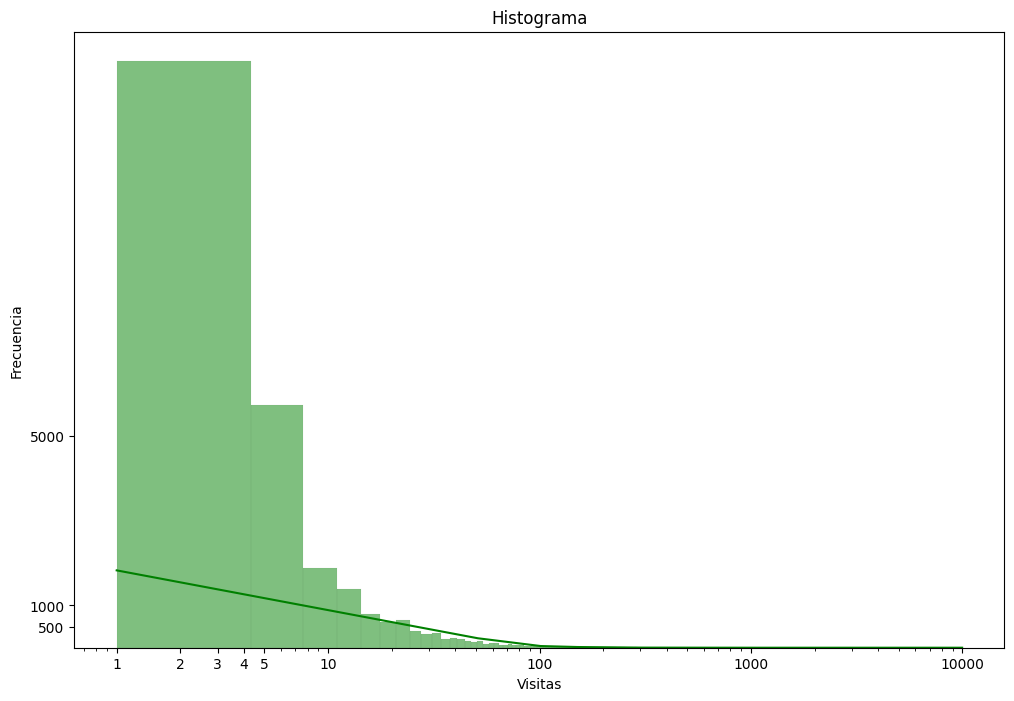

In [ ]:
# Plotting the histogram
plt.figure(figsize=(12, 8))
sns.histplot(views, kde=True, color='green', bins=3000)
plt.title('Histograma')
plt.xlabel('Visitas')
plt.ylabel('Frecuencia')

# Set the x and y axes to a logarithmic scale
plt.xscale('log')
#plt.yscale('log')

# Custom tick values for x and y axes
x_ticks = [1, 2, 3, 4, 5, 10, 100, 1000, 10000]  # Example tick values for the x-axis
y_ticks = [500, 1000, 5000]  # Example tick values for the y-axis

# Apply custom ticks to both axes
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)

# Optionally, format the ticks for better readability
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y)}'))

# Display the plot
plt.show()


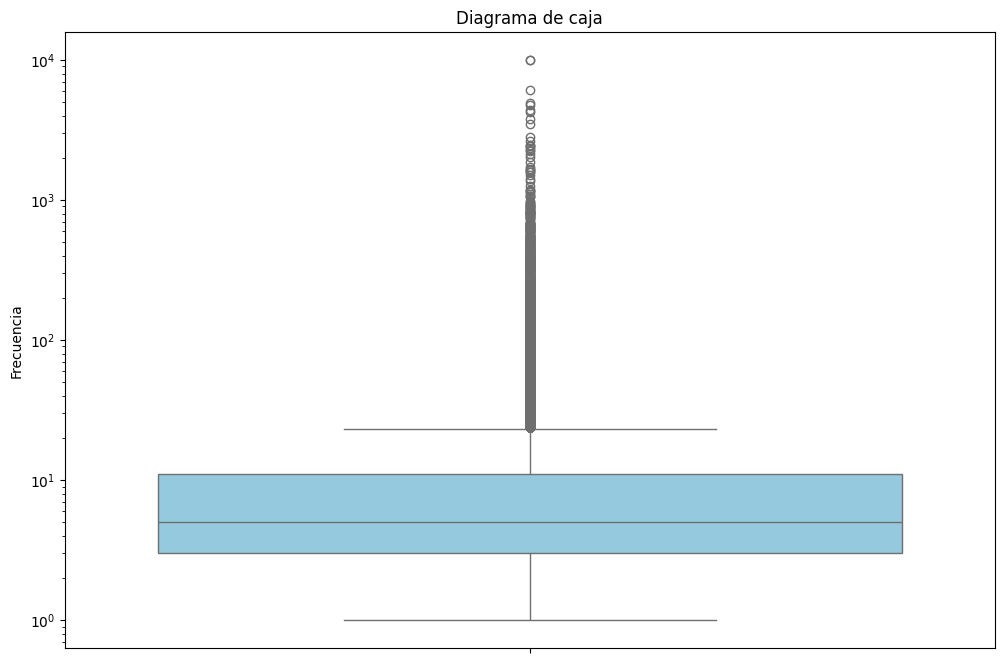

In [ ]:
# Plotting the boxplot
plt.figure(figsize=(12, 8))

# Calculate mean and quartiles
mean_value = np.mean(views)
q1 = np.percentile(views, 25)
q3 = np.percentile(views, 75)


sns.boxplot(data=views, color='skyblue', orient='v')
plt.title('Diagrama de caja')
plt.ylabel('Frecuencia')

# Annotate the mean and quartile values on the boxplot
#plt.text(0.05, mean_value, f'Promedio: {mean_value:.0f}', color='blue', fontsize=10)
#plt.text(0.05, q1, f'Q1: {q1:.0f}', color='blue', fontsize=10)
#plt.text(0.05, q3, f'Q3: {q3:.0f}', color='blue', fontsize=10)

# Set the x and y axes to a logarithmic scale
#plt.xscale('log')
plt.yscale('log')

# Display the plot
plt.show()

### Duración de la publicación

In [152]:
#get job duration values
def get_duration(row):
    if pd.notna(row['closed_time']):
        return row['closed_time'] - row['listed_time']
    else:
        return None

df_num['duration'] = df_num.apply(get_duration, axis=1)
duration = df_num['duration'].dropna()

#### Medidas de Centralización

In [23]:
#mean duration of postings
mean_duration = duration.mean()

#median duration of postings
median_duration = duration.median()

#mode duration of postings
mode_duration = duration.mode()


cent_data_duration = {
    'Medida': ['Promedio', 'Mediana', 'Moda'],
    'Duración de la publicación': [convert_time(mean_duration), convert_time(median_duration), convert_time(mode_duration[0])]
}

# Display Markdown table
#markdown_table = dict_to_markdown(cent_data_duration)
#display(Markdown(markdown_table))

# Display pandas dataframe table
dict_to_dataframe_table(cent_data_duration,'Medida')

,Promedio,Mediana,Moda
Duración de la publicación,34d17h0.5m,12d15h3.3m,0d18h36.7m


#### Medidas de Dispersión

In [29]:
#varianza
var_duration = duration.var()

#desviacion estandar
std_duration = duration.std()

#max
max_duration = duration.max()

#min
min_duration = duration.min()

#rango
range_duration = max_duration - min_duration

#coef asimetria
asim_duration = asim(duration)

#curtosis
kurt_duration = duration.kurt()


disp_data_duration = {
    'Medida': ['Varianza', 'Desviación Estándar', 'Rango', 'Coeficiente de Asimetría', 'Curtosis'],
    'Número de vistas': [convert_time(var_duration), convert_time(std_duration), (convert_time(min_duration),convert_time(max_duration)), round(asim_duration,3), round(kurt_duration,3)]
}



# Display Markdown table
#markdown_table = dict_to_markdown(disp_data_duration)
#display(Markdown(markdown_table))

# Display pandas dataframe table
dict_to_dataframe_table(disp_data_duration,'Medida')

,Varianza,Desviación Estándar,Rango,Coeficiente de Asimetría,Curtosis
Número de vistas,247021311d5h9.5m,53d11h16.8m,"(0d3h3.3m, 247d7h33.3m)",2.484,6.56


#### Análisis Intercuartílico

In [ ]:
#iqr rango intercuartil
#q1 25
#q2 50
#q3 75

In [ ]:
def get_cuartiles_iqr(columna):
    # Verificamos si la columna existe en el DataFrame
    if columna not in data.columns:
        print(f"La columna '{columna}' no se encuentra en el DataFrame.")
        return

    # Calculamos los cuartiles
    Q1 = data[columna].quantile(0.25)
    Q2 = data[columna].quantile(0.50)  # Mediana
    Q3 = data[columna].quantile(0.75)

    # Calculamos el Rango Intercuartílico (IQR)
    IQR = Q3 - Q1

    # Devolvemos los resultados como un diccionario
    resultado = {
        'Q1': Q1,
        'Q2': Q2,
        'Q3': Q3,
        'IQR': IQR
    }

    return resultado

# Calcular cuartiles de cada columna
quarts = {}
for x in data.columns:
    quarts[x] = get_cuartiles_iqr(x)

# Mostrar cuartiles e IQR  de todas las columnas
print("Cuartiles y Rango Intercuartil (IQR):")
for columna, curt in curts.items():
    print(f"{columna}:")
    print(f"\t IQR = {quarts[columna]['IQR']}")
    print(f"\t Q1 (25%)= {quarts[columna]['Q1']}")
    print(f"\t Q2 (50%)= {quarts[columna]['Q2']}")
    print(f"\t Q3 (75%)= {quarts[columna]['Q3']}")

#### Visualización

In [156]:

df_duration = pd.DataFrame(duration)
df_duration = df_duration.reset_index().rename(columns={'index':'local_ids','duration': 'duration'})
df_duration

,local_ids,duration
0,221,243000.0
1,520,523000.0
2,742,63000.0
3,1222,7508000.0
4,1436,467000.0
...,...,...
125,100021,2730000.0
126,103738,13000.0
127,103802,57000.0
128,111054,1429000.0


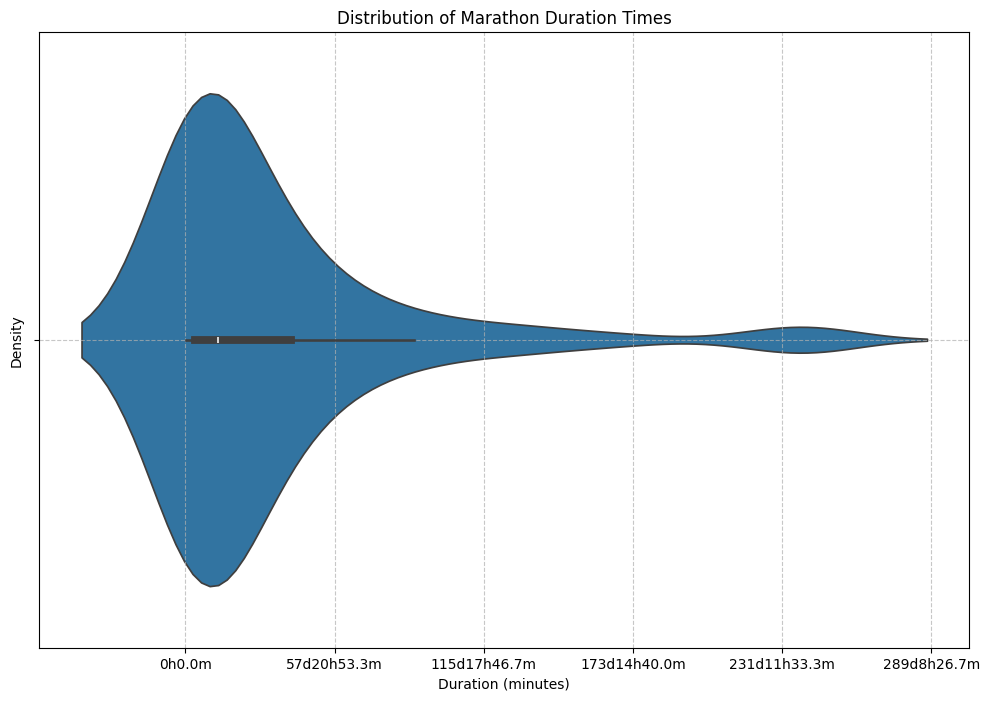

In [186]:
import matplotlib.ticker as ticker
def format_time(duration, pos):
    #convert unix time to days, hours, minutes
    minutes = round((duration%3600)/60,1)
    hours = int((duration%86400)//3600)
    if duration//86400 > 0:
        days = int(duration//86400)
        return f"{days}d{hours}h{minutes}m"
    else:
        return f"{hours}h{minutes}m"

# Create a violin plot
plt.figure(figsize=(12,8))
sns.violinplot(data=df_duration,x='duration',inner='box')

# Apply custom tick format
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

# Add lines to ticks
plt.grid(True,which='major', linestyle='--',alpha=0.7)

# Customize plot
plt.title("Distribution of Marathon Duration Times")
plt.xlabel("Duration (minutes)")
plt.ylabel("Density")

# Show the plot
plt.show()

C:\Users\Sarah\AppData\Local\Temp\ipykernel_11220\390195565.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='duration', data=df_duration, jitter=True,palette='CMRmap', alpha=0.7)


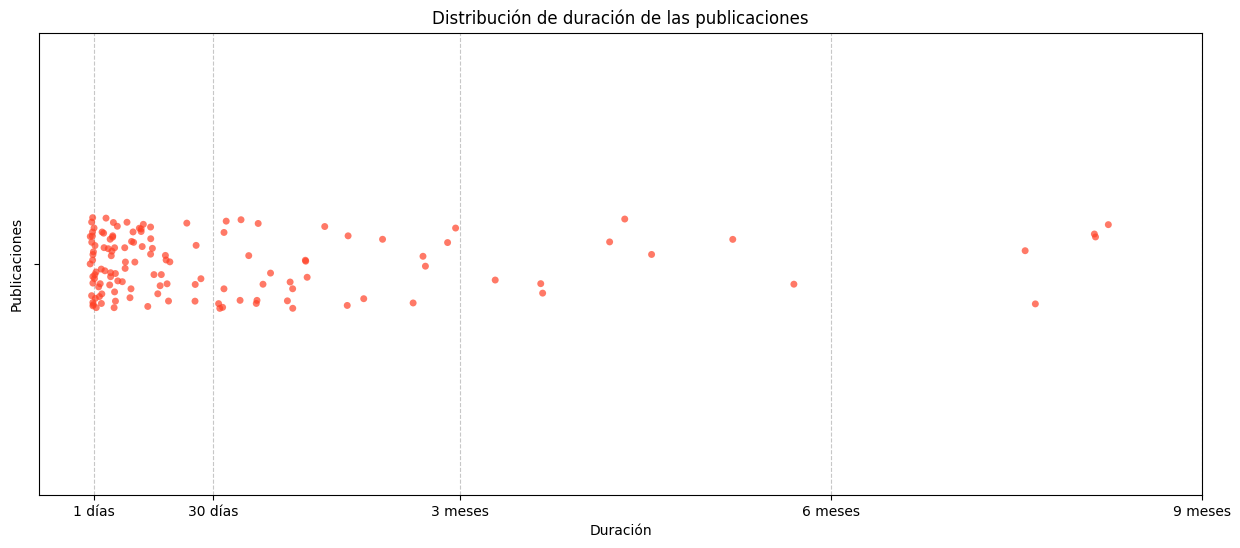

In [201]:
plt.figure(figsize=(15, 6))
sns.stripplot(x='duration', data=df_duration, jitter=True,palette='CMRmap', alpha=0.7)
def format_time(duration,pos):
    #convert unix time to days, hours, minutes
    minutes = round((duration%3600)/60,1)
    hours = int((duration%86400)//3600)
    if duration//86400 > 0:
        days = int(duration//86400)
        if duration//86400 > 60:
            months = int(duration//(86400*30))
            days = int((duration%(86400*30))//86400)
            return f"{months} meses"
        else:
            return f"{days} días"
    else:
        return f"{hours} horas"
    
time_labels = [86400, 2592000, 7776000, 15552000, 23328000]

plt.gca().set_xticks(time_labels)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))

plt.yticks(ticks=[0], labels=[''])

# Add lines to ticks
plt.grid(True,which='major', linestyle='--',alpha=0.7,axis='x')

plt.ylabel('Publicaciones')
plt.xlabel('Duración')
plt.title('Distribución de duración de las publicaciones')

plt.show()

In [ ]:
# Plotting the histogram
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)  # (rows, columns, index)
sns.histplot(apps, kde=True, color='green', bins=30)
plt.title('Histograma')
plt.xlabel('Visitas')
plt.ylabel('Frecuencia')

# Calculate mean and quartiles
mean_value = np.mean(apps)
q1 = np.percentile(apps, 25)
q3 = np.percentile(apps, 75)

# Plotting the boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=views, color='skyblue', orient='v')
plt.title('Diagrama de caja')
plt.ylabel('Salario promedio')

# Annotate the mean and quartile values on the boxplot
#plt.text(0.05, mean_value, f'Promedio: {mean_value:.0f}', color='blue', fontsize=10)
#plt.text(0.05, q1, f'Q1: {q1:.0f}', color='blue', fontsize=10)
#plt.text(0.05, q3, f'Q3: {q3:.0f}', color='blue', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()

## Análisis de atributos cualitativos

In [ ]:
df_merged = df_postings.merge(df_companies, left_on='company_id', right_on='company_id', how='left')

#setting the colors
colors = sns.color_palette('viridis', 7)


# Plotting the boxplot
plt.figure(figsize=(10,5))
sns.boxplot(x='company_size', y='med_salary', data=df_merged,palette=colors)
plt.title('Distribución de salarios por tamaño de empresa')
plt.xlabel('Tamaño de la empresa')
plt.ylabel('Salario medio')
plt.xticks(rotation=45)
plt.show()

La mediana de los salarios no varía significativamente entre diferentes tamaños de empresa.
Hay muchos valores atípicos, lo que indica que algunos empleados en empresas de cualquier tamaño pueden recibir salarios considerablemente más altos.
Aunque se podría esperar que empresas más grandes pagaran mejor, este gráfico sugiere que la variabilidad dentro de cada grupo es alta y que el tamaño de la empresa no es necesariamente un indicador claro del salario.

In [ ]:

experience_level_distribution = df_postings['formatted_experience_level'].value_counts()

custom_order = ['Internship', 'Entry level', 'Associate', 'Mid-Senior level', 'Director', 'Executive']

experience_level_distribution = experience_level_distribution.reindex(custom_order)

#Dict of colors for each experience level
experience_colors = {
    'Entry level': '#1c1aaf',
    'Associate': '#006b3d',
    'Mid-Senior level': '#fdcc0c',
    'Director': '#c23b21',
    'Not Applicable': '#888888',
    'Internship': '#0066e7',
    'Executive': '#a11c0f'
}

# Define base colors (can be any color scheme)
base_colors = [experience_colors.get(level) for level in experience_level_distribution.index]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
experience_level_distribution.plot(kind='bar', color=base_colors)
plt.title('Distribución de requerimientos de experiencia laboral en las ofertas de trabajo')
plt.xlabel('Nivel de experiencia')
plt.ylabel('Número de ofertas')
plt.xticks(rotation=45)
plt.show()

La mayoría de las ofertas de empleo están dirigidas a personas con experiencia media o en su primer empleo, lo que sugiere una alta demanda en estos niveles.
Las oportunidades para roles directivos o ejecutivos son mucho más limitadas, lo cual es esperable, ya que estos puestos requieren más experiencia y son menos comunes.
Las pasantías (Internship) son escasas, lo que podría indicar una menor oferta de oportunidades para estudiantes o recién graduados.
Este patrón sugiere que las empresas buscan principalmente talento joven y personas con experiencia intermedia, mientras que los roles de alto nivel son menos accesibles.

In [ ]:
# Sample Data
companies = ['Google', 'Amazon', 'Microsoft']
job_counts = [120, 150, 100]
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Define base colors (can be any color scheme)
base_colors = ['#4CAF50', '#FF9800', '#2196F3'] # Green, Orange, Blue

# Create a gradient effect by layering transparent bars
num_layers = 10 # More layers = smoother gradient
for i in range(num_layers):
    alpha = (i + 1) / num_layers # Increasing opacity
    for j, value in enumerate(job_counts):
        ax.bar(companies[j], value * (i + 1) / num_layers, color=base_colors[j], alpha=alpha, edgecolor='none')

# Labels & Title
plt.xlabel('Company', fontsize=12, fontweight='bold')
plt.ylabel('Number of Job Postings', fontsize=12, fontweight='bold')
plt.title('Job Postings Per Company (Gradient Effect)', fontsize=14, fontweight='bold')

# Format Ticks
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Add Grid
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate Bars
for i, value in enumerate(job_counts):
    plt.text(i, value + 5, str(value), ha='center', fontsize=12, fontweight='bold', color='black')
    
# Remove Borders (Spines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [ ]:
#IMPORTANTE: CERRAR LA CONEXIÓN
conn.close()